In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
sess = tf.Session()
iris = datasets.load_iris()
num_pts = len(iris.data)
num_feats = len(iris.data[0])

In [3]:
k=3
generations = 25
data_points = tf.Variable(iris.data)
cluster_labels = tf.Variable(tf.zeros([num_pts], dtype=tf.int64))

In [4]:
rand_starts = np.array([iris.data[np.random.choice(len(iris.data))] for _ in range(k)])
centroids = tf.Variable(rand_starts)

In [5]:
centroid_matrix = tf.reshape(tf.tile(centroids, [num_pts, 1]), [num_pts, k, num_feats])
point_matrix = tf.reshape(tf.tile(data_points, [1, k]), [num_pts, k, num_feats])
distances = tf.reduce_sum(tf.square(point_matrix - centroid_matrix), axis=2)

In [6]:
centroid_group = tf.argmin(distances, 1)

In [7]:
def data_group_avg(group_ids, data):
    sum_total = tf.unsorted_segment_sum(data, group_ids, 3)
    num_total = tf.unsorted_segment_sum(tf.ones_like(data), group_ids, 3)
    avg_by_group = sum_total/num_total
    return(avg_by_group)
means = data_group_avg(centroid_group, data_points)
update = tf.group(centroids.assign(means), cluster_labels.assign(centroid_group))

In [8]:
init = tf.global_variables_initializer()
sess.run(init)

In [9]:
for i in range(generations):
    print('Calculating gen {}, out of {}.'.format(i, generations))
    _, centroid_group_count = sess.run([update, centroid_group])
    group_count = []
    for ix in range(k):
        group_count.append(np.sum(centroid_group_count==ix))
    print('Group counts: {}'.format(group_count))

Calculating gen 0, out of 25.
Group counts: [54, 44, 52]
Calculating gen 1, out of 25.
Group counts: [53, 46, 51]
Calculating gen 2, out of 25.
Group counts: [50, 40, 60]
Calculating gen 3, out of 25.
Group counts: [50, 38, 62]
Calculating gen 4, out of 25.
Group counts: [50, 38, 62]
Calculating gen 5, out of 25.
Group counts: [50, 38, 62]
Calculating gen 6, out of 25.
Group counts: [50, 38, 62]
Calculating gen 7, out of 25.
Group counts: [50, 38, 62]
Calculating gen 8, out of 25.
Group counts: [50, 38, 62]
Calculating gen 9, out of 25.
Group counts: [50, 38, 62]
Calculating gen 10, out of 25.
Group counts: [50, 38, 62]
Calculating gen 11, out of 25.
Group counts: [50, 38, 62]
Calculating gen 12, out of 25.
Group counts: [50, 38, 62]
Calculating gen 13, out of 25.
Group counts: [50, 38, 62]
Calculating gen 14, out of 25.
Group counts: [50, 38, 62]
Calculating gen 15, out of 25.
Group counts: [50, 38, 62]
Calculating gen 16, out of 25.
Group counts: [50, 38, 62]
Calculating gen 17, out 

In [10]:
[centers, assignments] = sess.run([centroids, cluster_labels])
def most_common(my_list):
    return(max(set(my_list), key=my_list.count))
label0 = most_common(list(assignments[0:50]))
label1 = most_common(list(assignments[50:100]))
label2 = most_common(list(assignments[100:150]))
group0_count = np.sum(assignments[0:50]==label0)
group1_count = np.sum(assignments[50:100]==label1)
group2_count = np.sum(assignments[100:150]==label2)
accuracy = (group0_count + group1_count + group2_count)/150.
print('Accuracy: {:.2}'.format(accuracy))

Accuracy: 0.89


In [11]:
pca_model = PCA(n_components=2)
reduced_data = pca_model.fit_transform(iris.data)
reduced_centers = pca_model.transform(centers)
h = .02
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
xx_pt = list(xx.ravel())
yy_pt = list(yy.ravel())
xy_pts = np.array([[x,y] for x,y in zip(xx_pt, yy_pt)])
mytree = cKDTree(reduced_centers)
dist, indexes = mytree.query(xy_pts)
indexes = indexes.reshape(xx.shape)

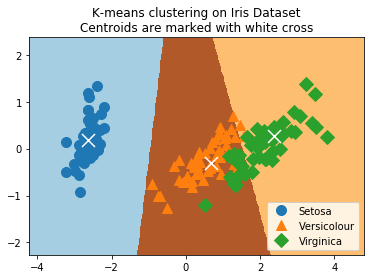

In [12]:
plt.figure(1)
plt.clf()
plt.imshow(indexes, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
symbols = ['o', '^', 'D']
label_name = ['Setosa', 'Versicolour', 'Virginica']
for i in range(3):
    temp_group = reduced_data[(i*50):(50)*(i+1)]
    plt.plot(temp_group[:, 0], temp_group[:, 1], symbols[i], markersize=10, label=label_name[i])
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on Iris Dataset\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='lower right')
plt.show()